# Identifying SRKW Orca Calls using CNN and SNN
## 02-Use CNN to identify SRKW calls

Import libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import glob
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

import tensorflow as tf
import tensorflow.keras.backend as K

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import  Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D
from tensorflow.keras.applications import DenseNet121

2022-08-20 22:46:57.385434: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
%matplotlib inline
np.random.seed(0)

Define directories

In [2]:
parentdir="../"
codedir=parentdir+"code/"
datadir=parentdir+"data/"
train_dir=datadir+"TrainDataLatest_PodCastAllRounds_123567910/"
test_dir=datadir+"TestDataLatest_PodCastAllRounds_123/"
output=parentdir+"output/"
specdir=output+"spectrogram/"
specdir_train=specdir+"train/all/"
specdir_test=specdir+"test/all/"

In [3]:
directory_filenames_train_pos = glob.glob(specdir_train + '*_pos.png')
directory_filenames_train_neg = glob.glob(specdir_train + '*_neg.png')
directory_filenames_test_pos = glob.glob(specdir_test + '*_pos.png')
directory_filenames_test_neg = glob.glob(specdir_test + '*_neg.png')

In [4]:
f=os.path.join(train_dir,'annotations.tsv')
anno_table=pd.read_csv(f, sep='\t')
del(f)

f=os.path.join(test_dir,'test.tsv')
test_table=pd.read_csv(f, sep='\t')
del(f)

 Read in spectrograms

In [5]:
spectrogram_pos=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_train_pos)):
    img=cv2.imread(directory_filenames_train_pos[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spectrogram_pos.append(img)
spectrogram_pos=np.asarray(spectrogram_pos, dtype=object)
del(i, img)

Check the errors list. If the list is not empty, regenerate those samples.

In [6]:
for i in errors:
    print(i, directory_filenames_train_pos[i])

In [7]:
spectrogram_neg=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_train_neg)):
    img=cv2.imread(directory_filenames_train_neg[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spectrogram_neg.append(img)
spectrogram_neg=np.asarray(spectrogram_neg, dtype=object)
del(i, img)

In [8]:
for i in errors:
    print(i, directory_filenames_train_neg[i])

In [9]:
index_pos=list(range(len(directory_filenames_train_pos)))
index_neg=list(range(len(directory_filenames_train_neg)))
listpos=np.full((len(directory_filenames_train_pos),1), 1.0)
listneg=np.full((len(directory_filenames_train_neg),1), 0.0)

In [10]:
# Split up the training data into 80% train and 20% validation. 
# There is a set aside testing data that we will not use in the training.  
X_pos_train, X_pos_validation, y_pos_train, y_pos_validation, index_pos_train, index_pos_validation = train_test_split(spectrogram_pos, listpos, index_pos, test_size=0.2, random_state=76)
X_neg_train, X_neg_validation, y_neg_train, y_neg_validation, index_neg_train, index_neg_validation = train_test_split(spectrogram_neg, listneg, index_neg, test_size=0.2, random_state=76)

 Mix up the positive and negative smaple again in the train and validation cohorts

In [11]:
x_train=np.concatenate([X_pos_train, X_neg_train])
y_train=np.concatenate([y_pos_train, y_neg_train])
x_validation=np.concatenate([X_pos_validation, X_neg_validation])
y_validation=np.concatenate([y_pos_validation, y_neg_validation])
print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(4329, 224, 224, 3)
(4329, 1)
(1084, 224, 224, 3)
(1084, 1)


Creating a set testing data following similar steps as above

In [12]:
spect_test_pos=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_test_pos)):
    img=cv2.imread(directory_filenames_test_pos[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spect_test_pos.append(img)
spect_test_pos=np.asarray(spect_test_pos, dtype=object)
del(i, img)

In [13]:
for i in errors:
    print(i, directory_filenames_test_pos[i])

In [14]:
spect_test_neg=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_test_neg)):
    img=cv2.imread(directory_filenames_test_neg[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spect_test_neg.append(img)
spect_test_neg=np.asarray(spect_test_neg, dtype=object)
del(i, img)

In [15]:
for i in errors:
    print(i, directory_filenames_test_neg[i])

In [16]:
index_test_pos=list(range(len(directory_filenames_test_pos)))
index_test_neg=list(range(len(directory_filenames_test_neg)))
listtestpos=np.full((len(directory_filenames_test_pos),1), 1.0)
listtestneg=np.full((len(directory_filenames_test_neg),1), 0.0)

In [17]:
x_test=np.concatenate([spect_test_pos, spect_test_neg])
y_test=np.concatenate([listtestpos, listtestneg])
print(x_test.shape)
print(y_test.shape)

(809, 224, 224, 3)
(809, 1)


In [18]:
number_of_classes = y_train.shape[1]
print(number_of_classes)
DenseNet121_conv = DenseNet121(weights='imagenet', include_top=False, input_shape=(nrow, ncol, 3))

1
29089792/29084464 [==============================] - 1s 0us/step


2022-08-20 22:56:46.970652: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-20 22:56:47.334799: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-20 22:56:47.659799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-08-20 22:56:47.659860: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-20 22:56:48.594399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-20 22:56:48.594593: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-08-20

In [19]:
for layer in DenseNet121_conv.layers:
    layer.trainable = True

for layer in DenseNet121_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f23f0ed9f70> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f18150d9d90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f17daf5dac0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f23f0edfca0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f17daf557f0> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f17daf55fa0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f17d854e5e0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f17daf55cd0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f17d854e430> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f17d855ef40> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f17d8561be0> True
<tensorflow.python.keras.

In [20]:
model = models.Sequential()
model.add(DenseNet121_conv)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(number_of_classes, activation='sigmoid'))
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer = optimizer, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              51381248  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

In [21]:
x_train=x_train.astype('float32')
y_train=y_train.astype('float32')
x_validation=x_validation.astype('float32')
y_validation=y_validation.astype('float32')
x_test=x_test.astype('float32')
y_test=y_test.astype('float32')

In [45]:
model_history = model.fit(x_train, y_train, batch_size=16, epochs=50, verbose=1, validation_data=(x_validation, y_validation))
y_train_pred_prob = model.predict(x_train)

Epoch 1/50
271/271 [==============================] - 136s 502ms/step - loss: 0.2050 - accuracy: 0.9513 - val_loss: 0.1937 - val_accuracy: 0.9428
Epoch 2/50
271/271 [==============================] - 137s 507ms/step - loss: 0.1307 - accuracy: 0.9709 - val_loss: 0.0853 - val_accuracy: 0.9788
Epoch 3/50
271/271 [==============================] - 137s 507ms/step - loss: 0.1506 - accuracy: 0.9647 - val_loss: 0.2077 - val_accuracy: 0.9225
Epoch 4/50
271/271 [==============================] - 137s 507ms/step - loss: 0.1208 - accuracy: 0.9658 - val_loss: 0.2268 - val_accuracy: 0.9262
Epoch 5/50
271/271 [==============================] - 137s 506ms/step - loss: 0.1261 - accuracy: 0.9700 - val_loss: 0.3252 - val_accuracy: 0.9013
Epoch 6/50
271/271 [==============================] - 137s 507ms/step - loss: 0.

Text(0.5, 1.0, 'Predicted Probability of All Training Samples')

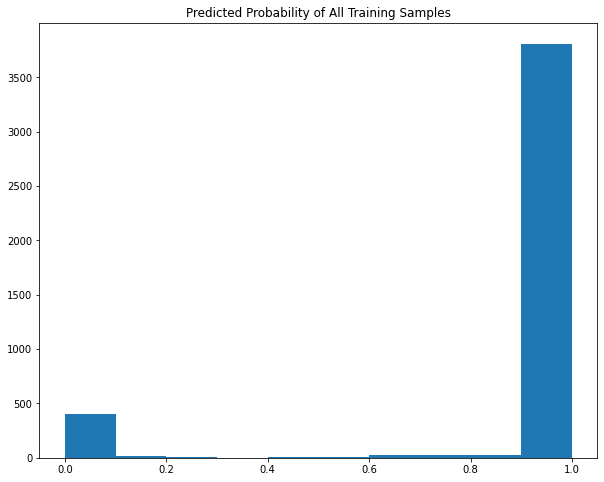

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(y_train_pred_prob[:,0])
ax.set_title('Predicted Probability of All Training Samples')

Prediction for labeled calls (Positive)

In [47]:
yhat_probs_Positive = model.predict(spectrogram_pos.astype('float32'))

Text(0.5, 1.0, 'Predicted Probability of Positive Calls')

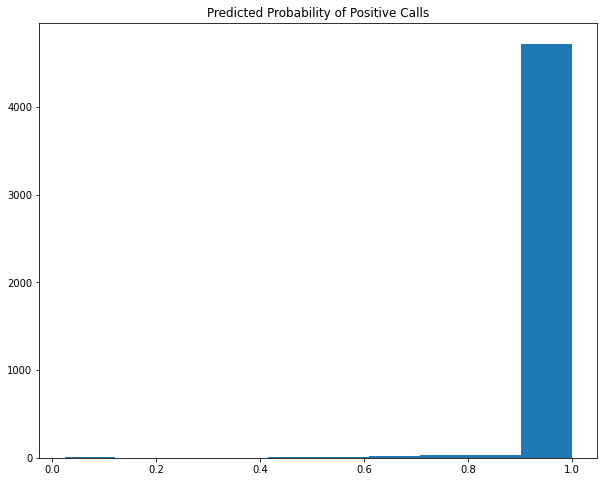

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_Positive[:,0])
ax.set_title('Predicted Probability of Positive Calls')

In [49]:
tp_train=len([i for i in yhat_probs_Positive if i>=0.5])
fn_train=len([i for i in yhat_probs_Positive if i<0.5])
fnr_train=(fn_train)/(tp_train+fn_train)
print('False Negative Rate on the training data:', '{:.2%}'.format(fnr_train))

False Negative Rate on the training data: 0.31%


Prediction for no calls (Negative)

In [50]:
yhat_probs_Negative = model.predict(spectrogram_neg.astype('float32'))

Text(0.5, 1.0, 'Predicted Probability of Negative Calls')

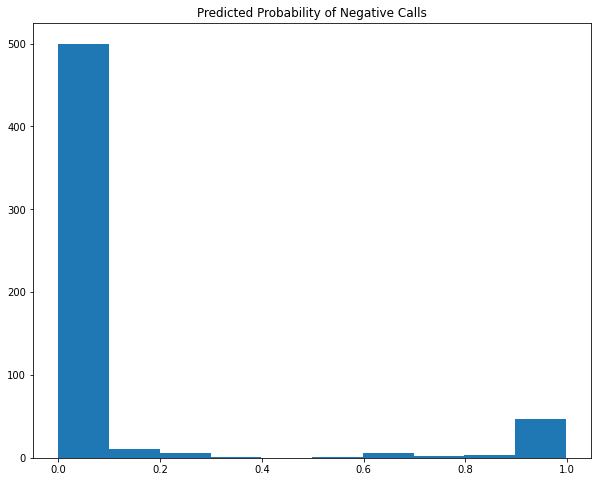

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_Negative[:,0])
ax.set_title('Predicted Probability of Negative Calls')

In [52]:
tn_train=len([i for i in yhat_probs_Negative if i<0.5])
fp_train=len([i for i in yhat_probs_Negative if i>=0.5])
fpr_train=(fp_train)/(tn_train+fp_train)
print('False Positive Rate on the training data:', '{:.2%}'.format(fpr_train))

False Positive Rate on the training data: 10.23%


In [53]:
precision_train = tp_train / (tp_train + fp_train)
recall_train = tp_train / (tp_train + fn_train)
accuracy_train = (tp_train + tn_train) / (tp_train + fp_train + tn_train + fn_train)
print('Training Accuracy: %.4f' % accuracy_train)
print('Training Precision: %.4f' % precision_train)
print('Training Recall: %.4f' % recall_train)

Training Accuracy: 0.9863
Training Precision: 0.9879
Training Recall: 0.9969


Model Evalutaion

In [54]:
yhat_probs_test = model.predict(x_test.astype('float32'))

Text(0.5, 1.0, 'Predicted Probability of Testing data')

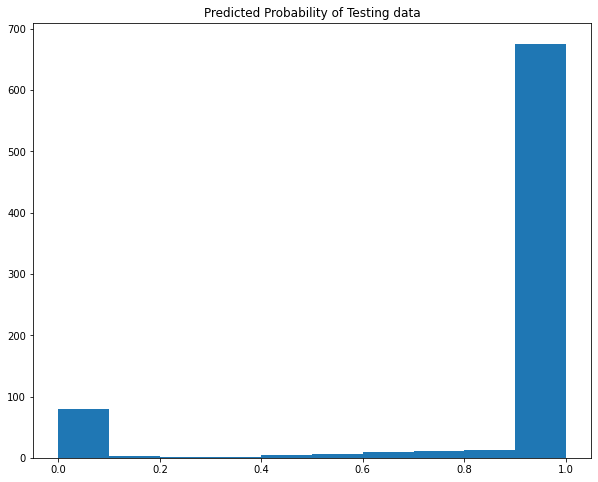

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_test[:,0])
ax.set_title('Predicted Probability of Testing data')

In [56]:
yhat_probs_test_pos=yhat_probs_test[:len(directory_filenames_test_pos)]
yhat_probs_test_neg=yhat_probs_test[len(directory_filenames_test_pos):]
print(len(yhat_probs_test_pos), len(yhat_probs_test_neg))

731 78


Text(0.5, 1.0, 'Predicted Probability of Positive Testing data')

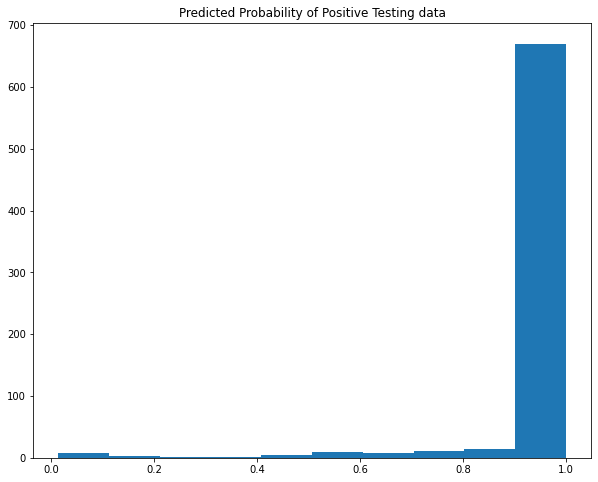

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_test_pos[:,0])
ax.set_title('Predicted Probability of Positive Testing data')

Text(0.5, 1.0, 'Predicted Probability of Negative Testing data')

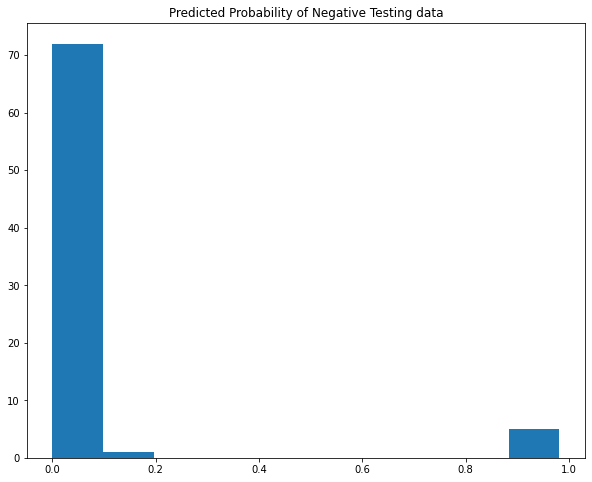

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_test_neg[:,0])
ax.set_title('Predicted Probability of Negative Testing data')

In [59]:
tp=len([i for i in yhat_probs_test_pos if i>=0.5])
fn=len([i for i in yhat_probs_test_pos if i<0.5])
tn=len([i for i in yhat_probs_test_neg if i<0.5])
fp=len([i for i in yhat_probs_test_neg if i>=0.5])
print(tp, fn, tn, fp)
false_negative_rate = fn / (tp + fn)
false_positive_rate = fp / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fp + tn + fn)
print('False Negative Rate:', '{:.2%}'.format(false_negative_rate))
print('False Positive Rate:', '{:.2%}'.format(false_positive_rate))

AUC = roc_auc_score(y_test, yhat_probs_test) 
print('AUC: %.4f' % AUC)
print('Accuracy: %.4f' % accuracy)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)

712 19 73 5
False Negative Rate: 2.60%
False Positive Rate: 6.41%
AUC: 0.9880
Accuracy: 0.9703
Precision: 0.9930
Recall: 0.9740


No handles with labels found to put in legend.


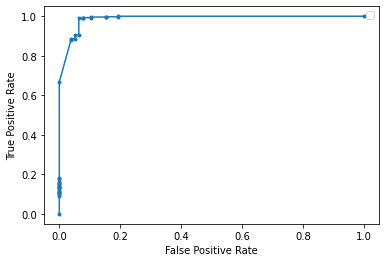

In [60]:
fpr, tpr, thresholds = roc_curve(y_test, yhat_probs_test)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


No handles with labels found to put in legend.


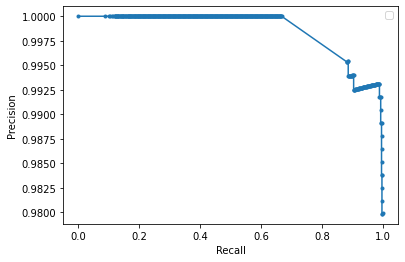

Precesion Recall AUC: 0.9986


In [61]:
precision, recall, thresholds = precision_recall_curve(y_test, yhat_probs_test)
precision_recall_auc = auc(recall, precision)
print('Precesion Recall AUC: %.4f' % precision_recall_auc)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [62]:
output_positive_test = pd.DataFrame()
output_positive_test['path']=directory_filenames_test_pos
output_positive_test['pred']=yhat_probs_test_pos

Take a look at some false negative and false positive plots

False Negative

streaming-orcasound-net_2019_11_14_13_02_00_53_pos.png


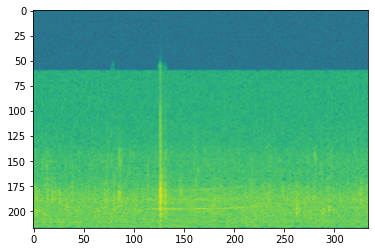

streaming-orcasound-net_2019_11_14_13_03_00_3_pos.png


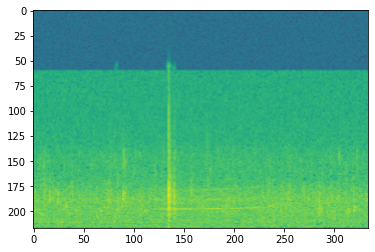

streaming-orcasound-net_2019_11_14_13_03_00_7_pos.png


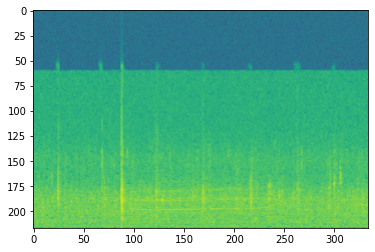

In [63]:
fnsample=output_positive_test.sort_values(by='pred', ascending=True).head(3)
for f in fnsample.path:
    print(f.split('/')[-1])
    img = mpimg.imread(f)
    imgplot = plt.imshow(img)
    plt.show()
del(f, img, imgplot)

Store false negative data to a csv file for later use.

In [64]:
fn_all=output_positive_test[output_positive_test.pred<0.5]
fn_all['wav_filename']=fn_all.path.apply(lambda x: '_'.join(x.split('/')[-1][:-8].split('_')[:-1])+'.wav')
fn_all['start_time_s']=fn_all.path.apply(lambda x: x.split('/')[-1][:-8].split('_')[-1])
tmptab=test_table
tmptab['start_time_s']=tmptab.start_time_s.apply(lambda x: str(int(x)))
fn_all=pd.merge(fn_all, tmptab, how='inner', on=['wav_filename', 'start_time_s'])
fn_all.to_csv(output+'false_neg.csv', index=False)
del(tmptab)

/tmp/ipykernel_8430/1154244724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fn_all['wav_filename']=fn_all.path.apply(lambda x: '_'.join(x.split('/')[-1][:-8].split('_')[:-1])+'.wav')
/tmp/ipykernel_8430/1154244724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fn_all['start_time_s']=fn_all.path.apply(lambda x: x.split('/')[-1][:-8].split('_')[-1])


In [65]:
output_negative_test = pd.DataFrame()
output_negative_test['path']=directory_filenames_test_neg
output_negative_test['pred']=yhat_probs_test_neg
output_negative_test_fp=output_negative_test[output_negative_test.pred>=0.5]

OS_9_27_2017_11_00_00__0004_0_neg.png


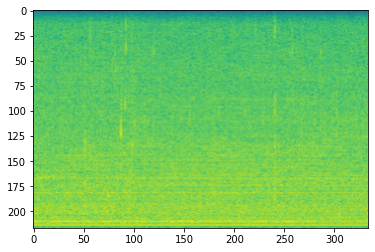

streaming-orcasound-net_2019_11_14_12_59_00_0_neg.png


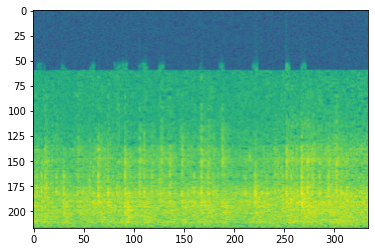

OS_9_27_2017_11_32_00__0002_0_neg.png


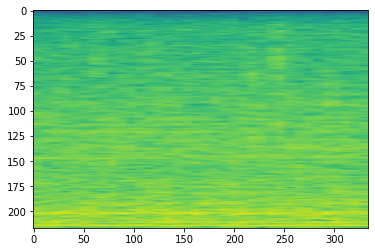

OS_9_27_2017_10_28_00__0001_0_neg.png


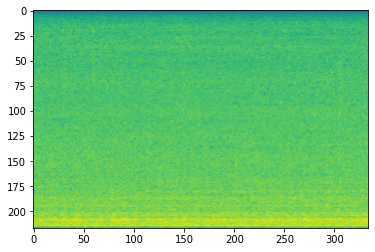

In [66]:
fpsample=output_negative_test.sort_values(by='pred', ascending=False).head(4)
for f in fpsample.path:
    print(f.split('/')[-1])
    img = mpimg.imread(f)
    imgplot = plt.imshow(img)
    plt.show()
del(f, img, imgplot)

Store false positive predictions to a csv file for later use.

In [67]:
fp_all=output_negative_test[output_negative_test.pred>=0.5]
fp_all['wav_filename']=fp_all.path.apply(lambda x: '_'.join(x.split('/')[-1][:-8].split('_')[:-1])+'.wav')
fp_all['start_time_s']=fp_all.path.apply(lambda x: x.split('/')[-1][:-8].split('_')[-1])
tmptab=test_table
tmptab['start_time_s']=tmptab.start_time_s.apply(lambda x: str(int(x)))
fp_all=pd.merge(fp_all, tmptab, how='inner', on=['wav_filename', 'start_time_s'])
fp_all.to_csv(output+'false_pos.csv', index=False)
del(tmptab)

/tmp/ipykernel_8430/3936791364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp_all['wav_filename']=fp_all.path.apply(lambda x: '_'.join(x.split('/')[-1][:-8].split('_')[:-1])+'.wav')
/tmp/ipykernel_8430/3936791364.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp_all['start_time_s']=fp_all.path.apply(lambda x: x.split('/')[-1][:-8].split('_')[-1])
